### Compare Listing 
<ol>
<li>a: vector uniform</li>
<li>b: greedy</li>
<li>c: e - greedy</li>
<li>d: decay e - greedy</li>
<li>e: Linear Reward Inaction (Pursuit Methods)</li>
<li>f: Linear Reward Penalty (Pursuit Methods)</li>
<li>g: UBC 1</li>
<li>h: UCB 1-Tuned</li>
<li>i: Thompson Sampling (beta)</li>
<li>j: Thompson Sampling (uniform)</li>
<li>k: Neural Network</li>
<li>l: softmax </li>
<li>m: Gradient Bandits</li>
</ol>

In [1]:
# import lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy,time,sys
import scipy.stats as stats
from scipy.stats import beta
plt.style.use('seaborn')
np.random.seed(5678)
np.set_printoptions(3)
tf.set_random_seed(678)
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
# setting the ground truth
num_bandit = 100
num_ep  = 20
num_iter= 1000
gt_prob = np.random.uniform(0,1,num_bandit)
optimal_choice = np.argmax(gt_prob)
print(gt_prob)
print('Best Choice: ',optimal_choice,gt_prob[optimal_choice])

[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736
 0.196 0.768 0.638 0.796 0.788 0.417 0.789 0.103 0.964 0.137 0.497 0.895
 0.766 0.019 0.309 0.631 0.984 0.932 0.619 0.275 0.633 0.14  0.8   0.659
 0.254 0.143 0.643 0.272 0.45  0.462 0.428 0.883 0.074 0.342 0.805 0.867
 0.994 0.207 0.315 0.598 0.396 0.437 0.993 0.48  0.91  0.117 0.262 0.765
 0.265 0.894 0.553 0.412 0.283 0.743 0.926 0.85  0.503 0.104 0.134 0.612
 0.317 0.25  0.387 0.605 0.141 0.069 0.044 0.019 0.8   0.805 0.012 0.818
 0.612 0.737 0.625 0.482 0.624 0.745 0.716 0.95  0.418 0.94  0.252 0.913
 0.664 0.153 0.804 0.122]
Best Choice:  48 0.9943540985119588


In [5]:
# a vectorized
a_expect = np.zeros((num_ep,num_bandit))
                    
for eps in range(num_ep):
    temp_expect = np.zeros(num_bandit)
    temp_choice = np.zeros(num_bandit)
                    
    for iter in range(num_iter//10):
        temp_choice    = temp_choice + 1
        current_reward = np.random.uniform(0,1,num_bandit) < gt_prob
        temp_expect    = temp_expect + current_reward

    a_expect[eps,:] = temp_expect/temp_choice
                    
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(a_expect.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736
 0.196 0.768 0.638 0.796 0.788 0.417 0.789 0.103 0.964 0.137 0.497 0.895
 0.766 0.019 0.309 0.631 0.984 0.932 0.619 0.275 0.633 0.14  0.8   0.659
 0.254 0.143 0.643 0.272 0.45  0.462 0.428 0.883 0.074 0.342 0.805 0.867
 0.994 0.207 0.315 0.598 0.396 0.437 0.993 0.48  0.91  0.117 0.262 0.765
 0.265 0.894 0.553 0.412 0.283 0.743 0.926 0.85  0.503 0.104 0.134 0.612
 0.317 0.25  0.387 0.605 0.141 0.069 0.044 0.019 0.8   0.805 0.012 0.818
 0.612 0.737 0.625 0.482 0.624 0.745 0.716 0.95  0.418 0.94  0.252 0.913
 0.664 0.153 0.804 0.122]
Expected 
[0.491 0.048 0.373 0.538 0.614 0.416 0.186 0.279 0.077 0.181 0.09  0.73
 0.194 0.757 0.629 0.791 0.795 0.412 0.792 0.102 0.96  0.141 0.493 0.889
 0.765 0.021 0.296 0.643 0.984 0.933 0.634 0.264 0.624 0.132 0.797 0.661
 0.245 0.138 0.633 0.293 0.455 0.471 0.419 0.882 0.074 0.35  0.819 0.86
 0.993 0.213 0.297 0.614 0.392 0.438 0.993 0.472 0.905 0.115 0.263 0.751
 0.2

In [6]:
# b greedy
b_pull_count   = np.zeros((num_ep,num_bandit))
b_estimation   = np.zeros((num_ep,num_bandit))
b_reward       = np.zeros((num_ep,num_iter))
b_optimal_pull = np.zeros((num_ep,num_iter))
b_regret_total = np.zeros((num_ep,num_iter))
                    
for eps in range(num_ep):
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    temp_regret = np.zeros(num_iter)
                    
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(temp_estimation)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + (1/(temp_pull_count[current_choice]+1)) * (current_reward-temp_estimation[current_choice])
        
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    b_pull_count[eps,:]   = temp_pull_count
    b_estimation[eps,:]   = temp_estimation
    b_reward[eps,:]       = temp_reward
    b_optimal_pull[eps,:] = temp_optimal_pull
    b_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(b_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736
 0.196 0.768 0.638 0.796 0.788 0.417 0.789 0.103 0.964 0.137 0.497 0.895
 0.766 0.019 0.309 0.631 0.984 0.932 0.619 0.275 0.633 0.14  0.8   0.659
 0.254 0.143 0.643 0.272 0.45  0.462 0.428 0.883 0.074 0.342 0.805 0.867
 0.994 0.207 0.315 0.598 0.396 0.437 0.993 0.48  0.91  0.117 0.262 0.765
 0.265 0.894 0.553 0.412 0.283 0.743 0.926 0.85  0.503 0.104 0.134 0.612
 0.317 0.25  0.387 0.605 0.141 0.069 0.044 0.019 0.8   0.805 0.012 0.818
 0.612 0.737 0.625 0.482 0.624 0.745 0.716 0.95  0.418 0.94  0.252 0.913
 0.664 0.153 0.804 0.122]
Expected 
[0.488 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.  

In [7]:
# c e greedy 
c_pull_count   = np.zeros((num_ep,num_bandit))
c_estimation   = np.zeros((num_ep,num_bandit))
c_reward       = np.zeros((num_ep,num_iter))
c_optimal_pull = np.zeros((num_ep,num_iter))
c_regret_total = np.zeros((num_ep,num_iter))
                    
for eps in range(num_ep):
    epsilon = np.random.uniform(0,1)
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    temp_regret = np.zeros(num_iter)
  
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(temp_expect) if epsilon < np.random.uniform(0,1) else np.random.choice(np.arange(num_bandit))
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + (1/(temp_pull_count[current_choice]+1)) * (current_reward-temp_estimation[current_choice])
        
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    c_pull_count[eps,:]   = temp_pull_count
    c_estimation[eps,:]   = temp_estimation
    c_reward[eps,:]       = temp_reward
    c_optimal_pull[eps,:] = temp_optimal_pull
    c_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(c_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736
 0.196 0.768 0.638 0.796 0.788 0.417 0.789 0.103 0.964 0.137 0.497 0.895
 0.766 0.019 0.309 0.631 0.984 0.932 0.619 0.275 0.633 0.14  0.8   0.659
 0.254 0.143 0.643 0.272 0.45  0.462 0.428 0.883 0.074 0.342 0.805 0.867
 0.994 0.207 0.315 0.598 0.396 0.437 0.993 0.48  0.91  0.117 0.262 0.765
 0.265 0.894 0.553 0.412 0.283 0.743 0.926 0.85  0.503 0.104 0.134 0.612
 0.317 0.25  0.387 0.605 0.141 0.069 0.044 0.019 0.8   0.805 0.012 0.818
 0.612 0.737 0.625 0.482 0.624 0.745 0.716 0.95  0.418 0.94  0.252 0.913
 0.664 0.153 0.804 0.122]
Expected 
[0.313 0.042 0.311 0.332 0.437 0.473 0.114 0.192 0.043 0.162 0.084 0.507
 0.116 0.564 0.544 0.562 0.565 0.289 0.592 0.075 0.679 0.057 0.407 0.662
 0.557 0.01  0.189 0.468 0.719 0.703 0.453 0.203 0.489 0.128 0.543 0.475
 0.185 0.167 0.45  0.171 0.259 0.359 0.268 0.683 0.06  0.26  0.573 0.661
 0.747 0.142 0.265 0.445 0.328 0.366 0.985 0.461 0.647 0.065 0.125 0.537
 0

In [8]:
# d decy e greedy 
d_pull_count   = np.zeros((num_ep,num_bandit))
d_estimation   = np.zeros((num_ep,num_bandit))
d_reward       = np.zeros((num_ep,num_iter))
d_optimal_pull = np.zeros((num_ep,num_iter))
d_regret_total = np.zeros((num_ep,num_iter))

for eps in range(num_ep):
    epsilon = 1.0
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
                    
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(temp_expect) if epsilon < np.random.uniform(0,1) else np.random.choice(np.arange(num_bandit))
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + (1/(temp_pull_count[current_choice]+1)) * (current_reward-temp_estimation[current_choice])
        
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
        # decay the eps
        epsilon = 0.99 * epsilon
        
    d_pull_count[eps,:]   = temp_pull_count
    d_estimation[eps,:]   = temp_estimation
    d_reward[eps,:]       = temp_reward
    d_optimal_pull[eps,:] = temp_optimal_pull
    d_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(d_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736
 0.196 0.768 0.638 0.796 0.788 0.417 0.789 0.103 0.964 0.137 0.497 0.895
 0.766 0.019 0.309 0.631 0.984 0.932 0.619 0.275 0.633 0.14  0.8   0.659
 0.254 0.143 0.643 0.272 0.45  0.462 0.428 0.883 0.074 0.342 0.805 0.867
 0.994 0.207 0.315 0.598 0.396 0.437 0.993 0.48  0.91  0.117 0.262 0.765
 0.265 0.894 0.553 0.412 0.283 0.743 0.926 0.85  0.503 0.104 0.134 0.612
 0.317 0.25  0.387 0.605 0.141 0.069 0.044 0.019 0.8   0.805 0.012 0.818
 0.612 0.737 0.625 0.482 0.624 0.745 0.716 0.95  0.418 0.94  0.252 0.913
 0.664 0.153 0.804 0.122]
Expected 
[0.175 0.013 0.178 0.108 0.188 0.25  0.075 0.05  0.075 0.037 0.013 0.154
 0.117 0.255 0.287 0.242 0.225 0.15  0.237 0.067 0.367 0.058 0.195 0.362
 0.283 0.    0.167 0.217 0.396 0.242 0.175 0.171 0.258 0.062 0.325 0.125
 0.11  0.025 0.18  0.05  0.196 0.085 0.133 0.342 0.05  0.113 0.217 0.258
 0.411 0.067 0.083 0.092 0.113 0.129 0.991 0.243 0.412 0.079 0.085 0.25
 0.

In [9]:
# e Linear Reward Inaction
e_pull_count   = np.zeros((num_ep,num_bandit))
e_estimation   = np.zeros((num_ep,num_bandit))
e_reward       = np.zeros((num_ep,num_iter))
e_optimal_pull = np.zeros((num_ep,num_iter))
e_regret_total = np.zeros((num_ep,num_iter))
      
for eps in range(num_ep):
    learning_rate = 0.1
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit) + 1.0/num_bandit
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.random.choice(num_bandit, p=temp_estimation)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        
        mask = np.zeros(num_bandit)
        mask[current_choice] = 1.0
        
        if current_reward == 1.0:
            temp_estimation = (mask) * (temp_estimation + learning_rate * (1-temp_estimation)) + (1-mask) * ( (1-learning_rate) * temp_estimation)
            
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    e_pull_count[eps,:]   = temp_pull_count
    e_estimation[eps,:]   = temp_estimation
    e_reward[eps,:]       = temp_reward
    e_optimal_pull[eps,:] = temp_optimal_pull
    e_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(np.around(e_estimation.mean(0),3))
print('Expected Normalized')
print(
    (gt_prob.max()-gt_prob.min())*(e_estimation.mean(0)-e_estimation.mean(0).min())/(e_estimation.mean(0).max()-e_estimation.mean(0).min()) + gt_prob.min()
)
e_estimation = (gt_prob.max()-gt_prob.min())*(e_estimation.mean(0)-e_estimation.mean(0).min())/(e_estimation.mean(0).max()-e_estimation.mean(0).min()) + gt_prob.min()

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736
 0.196 0.768 0.638 0.796 0.788 0.417 0.789 0.103 0.964 0.137 0.497 0.895
 0.766 0.019 0.309 0.631 0.984 0.932 0.619 0.275 0.633 0.14  0.8   0.659
 0.254 0.143 0.643 0.272 0.45  0.462 0.428 0.883 0.074 0.342 0.805 0.867
 0.994 0.207 0.315 0.598 0.396 0.437 0.993 0.48  0.91  0.117 0.262 0.765
 0.265 0.894 0.553 0.412 0.283 0.743 0.926 0.85  0.503 0.104 0.134 0.612
 0.317 0.25  0.387 0.605 0.141 0.069 0.044 0.019 0.8   0.805 0.012 0.818
 0.612 0.737 0.625 0.482 0.624 0.745 0.716 0.95  0.418 0.94  0.252 0.913
 0.664 0.153 0.804 0.122]
Expected 
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.05 0.   0.   0.   0.1  0.   0.   0.1  0.   0.   0.   0.
 0.   0.05 0.   0.   0.   0.   0.1  0.05 0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.1  0.05 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.05 0.   0.   0.   0.05 0.05 0.   0.   0.
 0.   0.   0.   0.   0

In [10]:
# f Linear Reward Penalty
f_pull_count   = np.zeros((num_ep,num_bandit))
f_estimation   = np.zeros((num_ep,num_bandit))
f_reward       = np.zeros((num_ep,num_iter))
f_optimal_pull = np.zeros((num_ep,num_iter))
f_regret_total = np.zeros((num_ep,num_iter))
                    
for eps in range(num_ep):
    alpha = 0.01
    beta  = 0.001
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit) + 1.0/num_bandit
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    
    for iter in range(num_iter):

        # select bandit / get reward /increase count / update estimate
        current_choice = np.random.choice(num_bandit, p=temp_estimation)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1

        mask = np.zeros(num_bandit)
        mask[current_choice] = 1.0
        
        if current_reward == 1.0:
            temp_estimation = (mask) * (temp_estimation + alpha * (1-temp_estimation)) + (1-mask) * ( (1-alpha) * temp_estimation)
        else: 
            temp_estimation = (mask) * ((1-beta) * temp_estimation) + (1-mask) * ( beta/(num_bandit-1) + (1-beta) * temp_estimation )

        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    f_pull_count[eps,:]   = temp_pull_count
    f_estimation[eps,:]   = temp_estimation
    f_reward[eps,:]       = temp_reward
    f_optimal_pull[eps,:] = temp_optimal_pull
    f_regret_total[eps,:] = temp_regret
    
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(f_estimation.mean(0))
print('Expected Normalized')
print(
    (gt_prob.max()-gt_prob.min())*(f_estimation.mean(0)-f_estimation.mean(0).min())/(f_estimation.mean(0).max()-f_estimation.mean(0).min()) + gt_prob.min()
)
f_estimation = (gt_prob.max()-gt_prob.min())*(e_estimation.mean(0)-e_estimation.mean(0).min())/(e_estimation.mean(0).max()-e_estimation.mean(0).min()) + gt_prob.min()

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736
 0.196 0.768 0.638 0.796 0.788 0.417 0.789 0.103 0.964 0.137 0.497 0.895
 0.766 0.019 0.309 0.631 0.984 0.932 0.619 0.275 0.633 0.14  0.8   0.659
 0.254 0.143 0.643 0.272 0.45  0.462 0.428 0.883 0.074 0.342 0.805 0.867
 0.994 0.207 0.315 0.598 0.396 0.437 0.993 0.48  0.91  0.117 0.262 0.765
 0.265 0.894 0.553 0.412 0.283 0.743 0.926 0.85  0.503 0.104 0.134 0.612
 0.317 0.25  0.387 0.605 0.141 0.069 0.044 0.019 0.8   0.805 0.012 0.818
 0.612 0.737 0.625 0.482 0.624 0.745 0.716 0.95  0.418 0.94  0.252 0.913
 0.664 0.153 0.804 0.122]
Expected 
[0.001 0.    0.    0.001 0.002 0.001 0.    0.    0.    0.    0.    0.007
 0.    0.011 0.004 0.013 0.019 0.001 0.018 0.    0.053 0.    0.001 0.042
 0.011 0.    0.    0.002 0.048 0.055 0.004 0.    0.005 0.    0.015 0.004
 0.    0.    0.004 0.    0.001 0.001 0.002 0.015 0.    0.    0.01  0.031
 0.086 0.    0.    0.003 0.    0.    0.07  0.002 0.041 0.    0.    0.008
 0

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


In [11]:
# g UBC 1
g_pull_count   = np.zeros((num_ep,num_bandit))
g_estimation   = np.zeros((num_ep,num_bandit))
g_reward       = np.zeros((num_ep,num_iter))
g_optimal_pull = np.zeros((num_ep,num_iter))
g_regret_total = np.zeros((num_ep,num_iter))

for eps in range(num_ep):
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
                    
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(temp_estimation + np.sqrt(0.5*np.log(iter+1)/(temp_pull_count+1)))
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + (1/(temp_pull_count[current_choice]+1)) * (current_reward-temp_estimation[current_choice])
        
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    g_pull_count[eps,:]   = temp_pull_count
    g_estimation[eps,:]   = temp_estimation
    g_reward[eps,:]       = temp_reward
    g_optimal_pull[eps,:] = temp_optimal_pull
    g_regret_total[eps,:] = temp_regret
  
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(g_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736
 0.196 0.768 0.638 0.796 0.788 0.417 0.789 0.103 0.964 0.137 0.497 0.895
 0.766 0.019 0.309 0.631 0.984 0.932 0.619 0.275 0.633 0.14  0.8   0.659
 0.254 0.143 0.643 0.272 0.45  0.462 0.428 0.883 0.074 0.342 0.805 0.867
 0.994 0.207 0.315 0.598 0.396 0.437 0.993 0.48  0.91  0.117 0.262 0.765
 0.265 0.894 0.553 0.412 0.283 0.743 0.926 0.85  0.503 0.104 0.134 0.612
 0.317 0.25  0.387 0.605 0.141 0.069 0.044 0.019 0.8   0.805 0.012 0.818
 0.612 0.737 0.625 0.482 0.624 0.745 0.716 0.95  0.418 0.94  0.252 0.913
 0.664 0.153 0.804 0.122]
Expected 
[0.35  0.013 0.212 0.37  0.403 0.265 0.067 0.12  0.029 0.113 0.042 0.597
 0.057 0.659 0.429 0.638 0.622 0.268 0.666 0.037 0.951 0.09  0.31  0.834
 0.676 0.    0.207 0.467 0.956 0.864 0.483 0.134 0.494 0.05  0.642 0.497
 0.199 0.071 0.513 0.13  0.262 0.283 0.315 0.808 0.05  0.198 0.71  0.652
 0.971 0.1   0.144 0.44  0.174 0.189 0.978 0.177 0.85  0.034 0.157 0.634
 0

In [12]:
# h UBC 1 Tuned
h_pull_count   = np.zeros((num_ep,num_bandit))
h_estimation   = np.zeros((num_ep,num_bandit))
h_reward       = np.zeros((num_ep,num_iter))
h_optimal_pull = np.zeros((num_ep,num_iter))
h_regret_total = np.zeros((num_ep,num_iter))

for eps in range(num_ep):
    temp_pull_count   = np.zeros(num_bandit) 
    temp_estimation   = np.zeros(num_bandit) 
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    temp_sumof_squares= np.zeros(num_bandit)
                    
    for iter in range(num_iter):
        
        v_temp = temp_sumof_squares + np.sqrt(2*np.log(iter+1)/(temp_pull_count+1))
        current_min_value = np.minimum(v_temp,np.ones_like(v_temp)*0.25)
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(temp_estimation + np.sqrt(np.log(iter+1)/(temp_pull_count+1)*current_min_value))
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + (1/(temp_pull_count[current_choice]+1)) * (current_reward-temp_estimation[current_choice])
        
        temp_sumof_squares[current_choice] = temp_sumof_squares[current_choice] + current_reward ** 2

        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    h_pull_count[eps,:]   = temp_pull_count
    h_estimation[eps,:]   = temp_estimation
    h_reward[eps,:]       = temp_reward
    h_optimal_pull[eps,:] = temp_optimal_pull
    h_regret_total[eps,:] = temp_regret
    
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(h_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736
 0.196 0.768 0.638 0.796 0.788 0.417 0.789 0.103 0.964 0.137 0.497 0.895
 0.766 0.019 0.309 0.631 0.984 0.932 0.619 0.275 0.633 0.14  0.8   0.659
 0.254 0.143 0.643 0.272 0.45  0.462 0.428 0.883 0.074 0.342 0.805 0.867
 0.994 0.207 0.315 0.598 0.396 0.437 0.993 0.48  0.91  0.117 0.262 0.765
 0.265 0.894 0.553 0.412 0.283 0.743 0.926 0.85  0.503 0.104 0.134 0.612
 0.317 0.25  0.387 0.605 0.141 0.069 0.044 0.019 0.8   0.805 0.012 0.818
 0.612 0.737 0.625 0.482 0.624 0.745 0.716 0.95  0.418 0.94  0.252 0.913
 0.664 0.153 0.804 0.122]
Expected 
[0.251 0.    0.137 0.265 0.251 0.168 0.058 0.07  0.083 0.112 0.075 0.523
 0.067 0.57  0.4   0.459 0.416 0.216 0.597 0.033 0.914 0.02  0.208 0.675
 0.349 0.017 0.129 0.371 0.951 0.69  0.343 0.1   0.312 0.104 0.475 0.249
 0.117 0.05  0.428 0.07  0.169 0.188 0.245 0.6   0.033 0.092 0.389 0.558
 0.986 0.09  0.185 0.346 0.128 0.131 0.977 0.203 0.692 0.05  0.115 0.32
 0.

In [13]:
# i Thompson Sampling (beta) (slow)
i_pull_count   = np.zeros((num_ep,num_bandit))
i_estimation   = np.zeros((num_ep,num_bandit))
i_reward       = np.zeros((num_ep,num_iter))
i_optimal_pull = np.zeros((num_ep,num_iter))
i_regret_total = np.zeros((num_ep,num_iter))

for eps in range(num_ep):

    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
                    
    for iter in range(num_iter):
        
        theta_samples = [stats.beta(a=1+w,b=1+t-w).rvs(size=1) for t, w in zip(temp_pull_count, temp_estimation)]
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(theta_samples)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + current_reward
        
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    i_pull_count[eps,:]   = temp_pull_count
    i_estimation[eps,:]   = theta_samples
    i_reward[eps,:]       = temp_reward
    i_optimal_pull[eps,:] = temp_optimal_pull
    i_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(i_estimation.mean(0))

KeyboardInterrupt: 

In [ ]:
# j Thompson Sampling (uniform) (slow)
j_pull_count   = np.zeros((num_ep,num_bandit))
j_estimation   = np.zeros((num_ep,num_bandit))
j_reward       = np.zeros((num_ep,num_iter))
j_optimal_pull = np.zeros((num_ep,num_iter))
j_regret_total = np.zeros((num_ep,num_iter))

for eps in range(num_ep):

    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
                    
    for iter in range(num_iter):
        
        theta_samples = [stats.uniform(w/(t+0.000000001),1-w/(t+0.000000001)).rvs(size=1) for t, w in zip(temp_pull_count, temp_estimation)]
        
        # select bandit / get reward /increase count / update estimate
        current_choice = np.argmax(theta_samples)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + current_reward
        
        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    j_pull_count[eps,:]   = temp_pull_count
    j_estimation[eps,:]   = theta_samples
    j_reward[eps,:]       = temp_reward
    j_optimal_pull[eps,:] = temp_optimal_pull
    j_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(j_estimation.mean(0))

In [14]:
# k neural network (with adam)
k_pull_count   = np.zeros((num_ep,num_bandit))
k_estimation   = np.zeros((num_ep,num_bandit))
k_reward       = np.zeros((num_ep,num_iter))
k_optimal_pull = np.zeros((num_ep,num_iter))
k_regret_total = np.zeros((num_ep,num_iter))

def sigmoid(x): return 1/(1+np.exp(-x))
def d_sigmoid(x): return sigmoid(x)*(1-sigmoid(x))

for eps in range(num_ep):
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit)
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    
    weights = np.random.randn(num_bandit,1)
    moment  = np.zeros_like(weights); 
    velocity = np.zeros_like(weights);
    epsilon  = 0.3

    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        if np.random.uniform(0,1)>epsilon:
            current_choice = np.argmax(weights)
            current_input  = np.zeros((1,num_bandit))
            current_input[0,current_choice] = 1
        else:
            current_choice = np.random.choice(np.arange(num_bandit))
            current_input  = np.zeros((1,num_bandit))
            current_input[0,current_choice] = 1

        layer1 = current_input @ weights
        layer1a= sigmoid(layer1)

        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_estimation[current_choice] = temp_estimation[current_choice] + current_reward
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        
        # KL Divergence https://timvieira.github.io/blog/post/2014/10/06/kl-divergence-as-an-objective-function/
        grad3 = np.log(layer1a+0.0000001) - np.log(temp_estimation[current_choice]/(temp_pull_count[current_choice])+0.0000001)
        grad2 = d_sigmoid(layer1)
        grad1 = current_input
        grad  = grad1.T @ (grad3 * grad2)
        
        moment   = 0.9*moment + (1-0.9) * grad
        velocity = 0.999*velocity + (1-0.999) * grad**2
        moment_hat   = moment/(1-0.9)
        velocity_hat = velocity/(1-0.999)
        weights  = weights - 0.08 * (moment_hat/(np.sqrt(velocity_hat)+1e-8))

        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
        # Decay the learning rate
        epsilon = epsilon * 0.999
        
    k_pull_count[eps,:]   = temp_pull_count
    k_estimation[eps,:]   = np.squeeze(sigmoid(weights))
    k_reward[eps,:]       = temp_reward
    k_optimal_pull[eps,:] = temp_optimal_pull
    k_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(k_estimation.mean(0))

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736
 0.196 0.768 0.638 0.796 0.788 0.417 0.789 0.103 0.964 0.137 0.497 0.895
 0.766 0.019 0.309 0.631 0.984 0.932 0.619 0.275 0.633 0.14  0.8   0.659
 0.254 0.143 0.643 0.272 0.45  0.462 0.428 0.883 0.074 0.342 0.805 0.867
 0.994 0.207 0.315 0.598 0.396 0.437 0.993 0.48  0.91  0.117 0.262 0.765
 0.265 0.894 0.553 0.412 0.283 0.743 0.926 0.85  0.503 0.104 0.134 0.612
 0.317 0.25  0.387 0.605 0.141 0.069 0.044 0.019 0.8   0.805 0.012 0.818
 0.612 0.737 0.625 0.482 0.624 0.745 0.716 0.95  0.418 0.94  0.252 0.913
 0.664 0.153 0.804 0.122]
Expected 
[0.438 0.334 0.403 0.346 0.507 0.45  0.272 0.457 0.276 0.419 0.352 0.547
 0.417 0.598 0.561 0.586 0.546 0.425 0.59  0.311 0.71  0.381 0.533 0.591
 0.655 0.25  0.309 0.548 0.698 0.613 0.56  0.382 0.61  0.366 0.626 0.46
 0.371 0.406 0.555 0.444 0.438 0.428 0.444 0.642 0.374 0.331 0.601 0.596
 0.719 0.341 0.308 0.503 0.338 0.406 0.719 0.483 0.644 0.328 0.415 0.637
 0.

In [15]:
# l softmax
l_pull_count   = np.zeros((num_ep,num_bandit))
l_estimation   = np.zeros((num_ep,num_bandit))
l_reward       = np.zeros((num_ep,num_iter))
l_optimal_pull = np.zeros((num_ep,num_iter))
l_regret_total = np.zeros((num_ep,num_iter))
                    
for eps in range(num_ep):
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit) + 1/num_bandit
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    temp_regret = np.zeros(num_iter)
    tempture = 30
                    
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        pi  = np.exp(temp_estimation/tempture) / np.sum(np.exp(temp_estimation/tempture))
        current_choice = np.random.choice(num_bandit,p=pi)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        temp_estimation[current_choice] = temp_estimation[current_choice] + (1/(temp_pull_count[current_choice]+1)) * (current_reward-temp_estimation[current_choice])

        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
        # decay the temp
        tempture = tempture * 0.99
        
    l_pull_count[eps,:]   = temp_pull_count
    l_estimation[eps,:]   = temp_estimation
    l_reward[eps,:]       = temp_reward
    l_optimal_pull[eps,:] = temp_optimal_pull
    l_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(l_estimation.mean(0))

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736
 0.196 0.768 0.638 0.796 0.788 0.417 0.789 0.103 0.964 0.137 0.497 0.895
 0.766 0.019 0.309 0.631 0.984 0.932 0.619 0.275 0.633 0.14  0.8   0.659
 0.254 0.143 0.643 0.272 0.45  0.462 0.428 0.883 0.074 0.342 0.805 0.867
 0.994 0.207 0.315 0.598 0.396 0.437 0.993 0.48  0.91  0.117 0.262 0.765
 0.265 0.894 0.553 0.412 0.283 0.743 0.926 0.85  0.503 0.104 0.134 0.612
 0.317 0.25  0.387 0.605 0.141 0.069 0.044 0.019 0.8   0.805 0.012 0.818
 0.612 0.737 0.625 0.482 0.624 0.745 0.716 0.95  0.418 0.94  0.252 0.913
 0.664 0.153 0.804 0.122]
Expected 
[0.464 0.047 0.25  0.522 0.426 0.272 0.105 0.169 0.029 0.113 0.058 0.5
 0.153 0.607 0.53  0.68  0.557 0.274 0.589 0.057 0.918 0.098 0.361 0.755
 0.587 0.011 0.22  0.478 0.884 0.818 0.404 0.156 0.541 0.09  0.742 0.573
 0.239 0.109 0.445 0.225 0.313 0.263 0.291 0.776 0.068 0.235 0.695 0.753
 0.851 0.161 0.262 0.448 0.286 0.245 0.91  0.338 0.746 0.086 0.229 0.66
 0.2 

In [16]:
# m gradient base
m_pull_count   = np.zeros((num_ep,num_bandit))
m_estimation   = np.zeros((num_ep,num_bandit))
m_reward       = np.zeros((num_ep,num_iter))
m_optimal_pull = np.zeros((num_ep,num_iter))
m_regret_total = np.zeros((num_ep,num_iter))
                    
for eps in range(num_ep):
    temp_pull_count   = np.zeros(num_bandit)
    temp_estimation   = np.zeros(num_bandit) + 1/num_bandit
    temp_reward       = np.zeros(num_iter)
    temp_optimal_pull = np.zeros(num_iter)
    temp_regret = np.zeros(num_iter)
    temp_mean_reward = 0
    alpha = 0.8
                    
    for iter in range(num_iter):
        
        # select bandit / get reward /increase count / update estimate
        pi  = np.exp(temp_estimation) / np.sum(np.exp(temp_estimation))
        current_choice = np.random.choice(num_bandit,p=pi)
        current_reward = 1 if np.random.uniform(0,1) < gt_prob[current_choice] else 0
        temp_pull_count[current_choice] = temp_pull_count[current_choice] + 1
        
        temp_mean_reward = temp_mean_reward + ((current_reward-temp_mean_reward))/(iter) if not iter==0 else ((current_reward-temp_mean_reward))
        mask = np.zeros(num_bandit)
        mask[current_choice] = 1
        
        temp_estimation = (mask)   * (temp_estimation+alpha*(current_reward-temp_mean_reward)*(1-pi)) + \
                          (1-mask) * (temp_estimation-alpha*(current_reward-temp_mean_reward)*(pi))

        # update reward and optimal choice
        temp_reward[iter] = current_reward if iter == 0 else temp_reward[iter-1] + current_reward
        temp_optimal_pull[iter] = 1 if current_choice == optimal_choice else 0
        temp_regret[iter] = gt_prob[optimal_choice] - gt_prob[current_choice] if iter == 0 else temp_regret[iter-1] + (gt_prob[optimal_choice] - gt_prob[current_choice])
        
    m_pull_count[eps,:]   = temp_pull_count
    m_estimation[eps,:]   = temp_estimation
    m_reward[eps,:]       = temp_reward
    m_optimal_pull[eps,:] = temp_optimal_pull
    m_regret_total[eps,:] = temp_regret
        
print('Ground Truth')
print(gt_prob)
print('Expected ')
print(np.around(m_estimation.mean(0),2))
print('Expected Normalized')
print(
    (gt_prob.max()-gt_prob.min())*(m_estimation.mean(0)-m_estimation.mean(0).min())/(m_estimation.mean(0).max()-m_estimation.mean(0).min()) + gt_prob.min()
)
m_estimation = (gt_prob.max()-gt_prob.min())*(m_estimation.mean(0)-m_estimation.mean(0).min())/(m_estimation.mean(0).max()-m_estimation.mean(0).min()) + gt_prob.min()

Ground Truth
[0.489 0.059 0.366 0.519 0.598 0.431 0.179 0.285 0.071 0.185 0.088 0.736
 0.196 0.768 0.638 0.796 0.788 0.417 0.789 0.103 0.964 0.137 0.497 0.895
 0.766 0.019 0.309 0.631 0.984 0.932 0.619 0.275 0.633 0.14  0.8   0.659
 0.254 0.143 0.643 0.272 0.45  0.462 0.428 0.883 0.074 0.342 0.805 0.867
 0.994 0.207 0.315 0.598 0.396 0.437 0.993 0.48  0.91  0.117 0.262 0.765
 0.265 0.894 0.553 0.412 0.283 0.743 0.926 0.85  0.503 0.104 0.134 0.612
 0.317 0.25  0.387 0.605 0.141 0.069 0.044 0.019 0.8   0.805 0.012 0.818
 0.612 0.737 0.625 0.482 0.624 0.745 0.716 0.95  0.418 0.94  0.252 0.913
 0.664 0.153 0.804 0.122]
Expected 
[-0.08 -0.66 -0.31 -0.12 -0.15 -0.35 -0.32 -0.23 -0.41 -0.65 -0.47  0.3
 -0.68  0.43  0.03  0.53  0.62 -0.34  0.74 -0.4   0.91 -0.44 -0.35  0.64
  0.29 -0.63 -0.43  0.2   1.64  0.92  0.11 -0.29 -0.12 -0.57  0.37 -0.
 -0.29 -0.67  0.12 -0.51 -0.07 -0.23 -0.18  1.52 -0.51 -0.47  0.13  1.
  0.8  -0.42 -0.41 -0.06 -0.5  -0.22  1.63 -0.18  0.55 -0.59 -0.43  0.57
 -0.37 

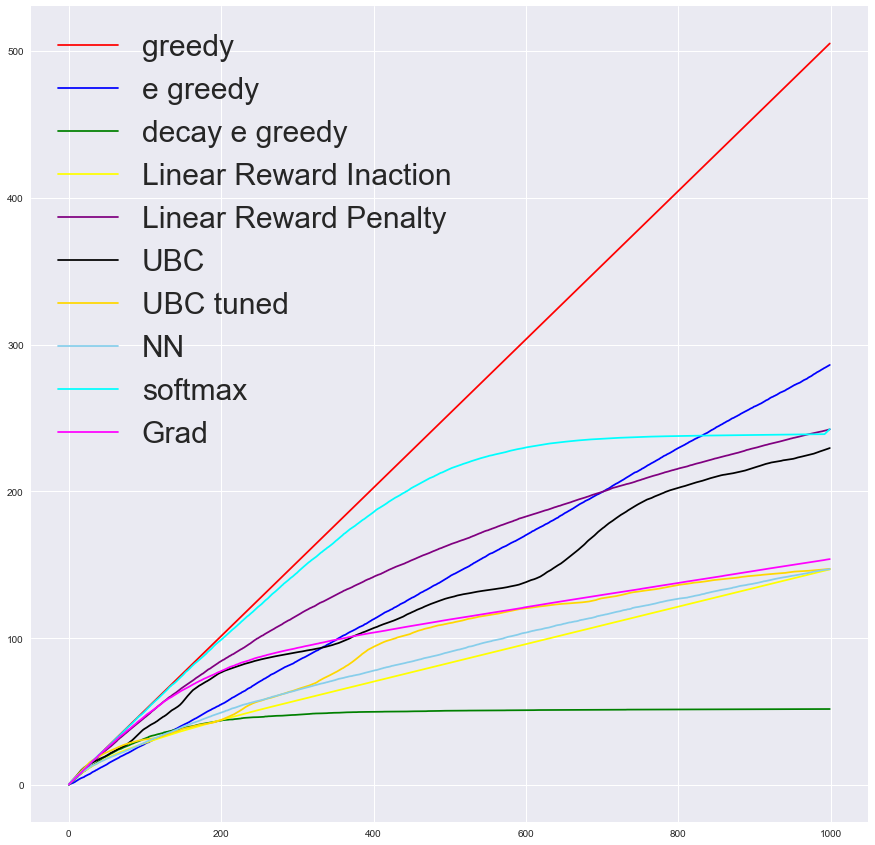

In [18]:
# plot the regret
plt.figure(figsize=(15,15))
plt.plot(b_regret_total.mean(0),c='red',    label='greedy')
plt.plot(c_regret_total.mean(0),c='blue',   label='e greedy')
plt.plot(d_regret_total.mean(0),c='green',  label='decay e greedy')
plt.plot(e_regret_total.mean(0),c='yellow', label='Linear Reward Inaction')
plt.plot(f_regret_total.mean(0),c='purple', label='Linear Reward Penalty')
plt.plot(g_regret_total.mean(0),c='black',  label='UBC')
plt.plot(h_regret_total.mean(0),c='gold',   label='UBC tuned')
# plt.plot(i_regret_total.mean(0),c='pink',   label='beta')
# plt.plot(j_regret_total.mean(0),c='grey',   label='uniform')
plt.plot(k_regret_total.mean(0),c='skyblue',label='NN')
plt.plot(l_regret_total.mean(0),c='cyan',   label='softmax')
plt.plot(m_regret_total.mean(0),c='magenta',label='Grad')
plt.legend(prop={'size': 30})
plt.show()

In [ ]:
# plot the reward
plt.figure(figsize=(15,15))
plt.plot(b_reward.mean(0),c='red',    label='greedy')
plt.plot(c_reward.mean(0),c='blue',   label='e greedy')
plt.plot(d_reward.mean(0),c='green',  label='decay e greedy')
plt.plot(e_reward.mean(0),c='yellow', label='Linear Reward Inaction')
plt.plot(f_reward.mean(0),c='purple', label='Linear Reward Penalty')
plt.plot(g_reward.mean(0),c='black',  label='UBC')
plt.plot(h_reward.mean(0),c='gold',   label='UBC tuned')
# plt.plot(i_reward.mean(0),c='pink',   label='beta')
# plt.plot(j_reward.mean(0),c='grey',   label='uniform')
plt.plot(k_reward.mean(0),c='skyblue',label='NN')
plt.plot(l_reward.mean(0),c='cyan',   label='softmax')
plt.plot(m_reward.mean(0),c='magenta',label='Grad')
plt.legend(prop={'size': 30})
plt.show()

In [ ]:
# plot the reward
print(gt_prob)
print(b_estimation.mean(0))
print(c_estimation.mean(0))
print(d_estimation.mean(0))
print(e_estimation)
print(f_estimation)
print(g_estimation.mean(0))
print(h_estimation.mean(0))
print(i_estimation.mean(0))
print(j_estimation.mean(0))
print(k_estimation.mean(0))
print(l_estimation.mean(0))
print(m_estimation)

In [ ]:
# correaltion
import pandas as pd
import seaborn as sns; sns.set()
data = pd.DataFrame({
        'GT':gt_prob,
        'Vector': a_expect.mean(0),
        'greedy':b_estimation.mean(0),
        'e-greedy':c_estimation.mean(0),
        'decay e-greedy':d_estimation.mean(0),
        'Linear Reward Inaction':e_estimation,
        'Linear Reward Penalty':f_estimation,
        'UCB1':g_estimation.mean(0),
        'UCB1 Tuned':h_estimation.mean(0),
        'beta':i_estimation.mean(0),
        'uniform':j_estimation.mean(0),
        'NN':k_estimation.mean(0),
        'softmax':l_estimation.mean(0),
        'grad':m_estimation
    })
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True,linewidths=1.5)
plt.show()

# Reference 
1. numpy.set_printoptions — NumPy v1.14 Manual. (2019). Docs.scipy.org. Retrieved 13 January 2019, from https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.set_printoptions.html
2. [ Archived Post ] Random Note about Multi-Arm Bandit Problem 2. (2019). Medium. Retrieved 13 January 2019, from https://medium.com/@SeoJaeDuk/archived-post-random-note-about-multi-arm-bandit-problem-2-5c522d1dfbdc
3. Vieira, T. (2014). KL-divergence as an objective function — Graduate Descent. Timvieira.github.io. Retrieved 13 January 2019, from https://timvieira.github.io/blog/post/2014/10/06/kl-divergence-as-an-objective-function/
4. Some Reinforcement Learning: The Greedy and Explore-Exploit Algorithms for the Multi-Armed Bandit Framework in Python. (2019). Datasciencecentral.com. Retrieved 13 January 2019, from https://www.datasciencecentral.com/profiles/blogs/some-reinforcement-learning-the-greedy-and-explore-exploit
5. (2019). Cs.mcgill.ca. Retrieved 13 January 2019, from https://www.cs.mcgill.ca/~vkules/bandits.pdf
